# Import Libraries

In [1]:
import sys
import datetime
from matplotlib import pyplot
from matplotlib.image import imread
from os import makedirs, listdir
from shutil import copyfile
from random import seed, random
from keras.utils import to_categorical
from keras.models import Sequential, Model, load_model
from keras.layers import Conv2D, MaxPooling2D, Dense, Flatten, Dropout
from keras.optimizers import SGD
from keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array
from keras.applications.vgg16 import VGG16

# Load and Explore Dataset

In [2]:
from google.colab import drive
drive.mount('/content/drive/')

Mounted at /content/drive/


In [ ]:
# import os
# for i in range(1000, 2000):
#   filename = 'drive/MyDrive/train/' + 'dog.' + str(i) + '.jpg'
#   os.remove(filename)
#   print("Removed ", filename)

In [ ]:
# foldername = 'drive/MyDrive/dataset/train/cats/'
# for filename in listdir(foldername):
#   os.remove(str(foldername) + str(filename))
#   print("Removed ", filename)

In [ ]:
# define location of dataset
folder = 'drive/MyDrive/train/'

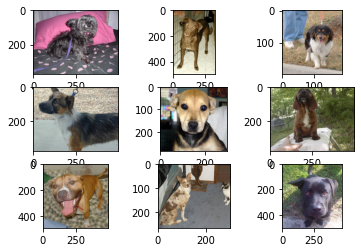

In [ ]:
# plot first few dog images
for i in range(9):
	# define subplot
	pyplot.subplot(330 + 1 + i)
	# define filename
	filename = folder + 'dog.' + str(i) + '.jpg'
	# load image pixels
	image = imread(filename)
	# plot raw pixel data
	pyplot.imshow(image)
# show the figure
pyplot.show()

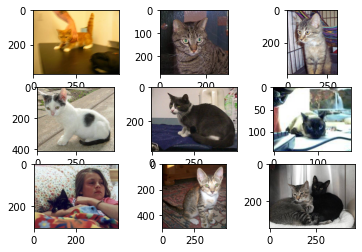

In [ ]:
# plot first few cat images
for i in range(9):
	# define subplot
	pyplot.subplot(330 + 1 + i)
	# define filename
	filename = folder + 'cat.' + str(i) + '.jpg'
	# load image pixels
	image = imread(filename)
	# plot raw pixel data
	pyplot.imshow(image)
# show the figure
pyplot.show()

All the photos have different dimensions (width and length).

# Split Data into Training and Testing Sets

The directory for the training and testing data is created with cats and dogs subdirectories.

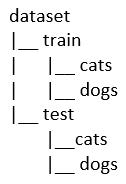

In [ ]:
# specify directories
home_dir = 'drive/MyDrive/dataset/'
sub_dirs = ['train/', 'test/']
class_dirs = ['cats/', 'dogs/']

# create directories
for sub_dir in sub_dirs:
	for class_dir in class_dirs:
		new_dir = home_dir + sub_dir + class_dir
		makedirs(new_dir, exist_ok=True)

The class label for each photo is determined based on the filenames. 

In [ ]:
# seed random number generator
seed(1)

# define ratio of data to use for validation
val_ratio = 0.25

# copy training and testing data into subdirectories
src_dir = 'drive/MyDrive/train/'
for filename in listdir(src_dir):
	src = src_dir + filename
	dst_dir = 'train/'
	if random() < val_ratio:
		dst_dir = 'test/'
	if filename.startswith('cat'):
		dst = home_dir + dst_dir + 'cats/' + filename
		copyfile(src, dst)
	else:
		dst = home_dir + dst_dir + 'dogs/' + filename
		copyfile(src, dst)

# Build a Baseline CNN Model

A function for defining a three-block VGG CNN model is created.
The dimension of the photos is 200 × 200 pixels.

In [3]:
def define_model():
  
	model = Sequential()
	model.add(Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same', input_shape=(200, 200, 3)))
	model.add(MaxPooling2D((2, 2)))
	model.add(Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
	model.add(MaxPooling2D((2, 2)))
	model.add(Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
	model.add(MaxPooling2D((2, 2)))
	model.add(Flatten())
	model.add(Dense(128, activation='relu', kernel_initializer='he_uniform'))
	model.add(Dense(1, activation='sigmoid'))
	
	opt = SGD(lr=0.001, momentum=0.9)
	model.compile(optimizer=opt, loss='binary_crossentropy', metrics=['accuracy'])
	return model

In [ ]:
model = define_model()
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_3 (Conv2D)            (None, 200, 200, 32)      896       
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 100, 100, 32)      0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 100, 100, 64)      18496     
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 50, 50, 64)        0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 50, 50, 128)       73856     
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 25, 25, 128)       0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 80000)            

An instance of the ImageDataGenerator is created to scale the pixel values to the range of 0-1.

In [ ]:
datagen = ImageDataGenerator(rescale=1.0/255.0)

Iterators for the training and testing data are created.

In [ ]:
train_it = datagen.flow_from_directory('drive/MyDrive/dataset/train/', class_mode='binary', batch_size=64, target_size=(200, 200))
test_it = datagen.flow_from_directory('drive/MyDrive/dataset/test/', class_mode='binary', batch_size=64, target_size=(200, 200))

Found 1518 images belonging to 2 classes.
Found 482 images belonging to 2 classes.


The model is fitted for 20 epochs to check whether the model can learn the problem.

In [ ]:
now = datetime.datetime.now
t = now()
history = model.fit_generator(train_it, steps_per_epoch=len(train_it),
	validation_data=test_it, validation_steps=len(test_it), epochs=20, verbose=0)
print('Training time: %s' % (now() - t))

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/training.py:1844: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Training time: 0:42:56.875441


The model is evaluated against the testing data.

In [ ]:
_, acc = model.evaluate_generator(test_it, steps=len(test_it), verbose=0)
print('> %.3f' % (acc * 100.0))

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/training.py:1877: UserWarning: `Model.evaluate_generator` is deprecated and will be removed in a future version. Please use `Model.evaluate`, which supports generators.
  warnings.warn('`Model.evaluate_generator` is deprecated and '


> 69.295


The accuracy of the baseline model is 69%.

"history" contains the model loss and accuracy on the training and testing data at the end of each epoch. Line plots of these measures over training epochs provide learning curves that can be used to determine whether the model is overfitting, underfitting, or has a good fit.

A function that plots the learning curves is created.

In [11]:
def plot_learning_curves(history):
	# plot loss
	pyplot.subplot(211)
	pyplot.title('Cross Entropy Loss')
	pyplot.plot(history.history['loss'], color='blue', label='train')
	pyplot.plot(history.history['val_loss'], color='orange', label='test')
	# plot accuracy
	pyplot.subplot(212)
	pyplot.title('Classification Accuracy')
	pyplot.plot(history.history['accuracy'], color='blue', label='train')
	pyplot.plot(history.history['val_accuracy'], color='orange', label='test')
	# save plot to file
	filename = sys.argv[0].split('/')[-1]
	pyplot.savefig(filename + '_plot.png')
	pyplot.close()

In [ ]:
plot_learning_curves(history)

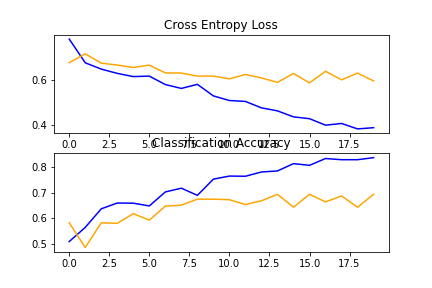

Based on the learning curves, overfitting is observed. There are two approaches to reduce overfitting, which are dropout regularization and image data augmentation.

Both of these approaches are expected to slow the rate of improvement during training. As such, the number of training epochs is increased from 20 to 50 to give the model more space for refinement.

# Improve the Model

## Dropout Regularization

A dropout of 20% is applied after each VGG block, with a larger dropout rate of 50% applied after the fully connected layer in the classifier part of the model.

In [ ]:
def define_dropout_model():

	model = Sequential()
	model.add(Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same', input_shape=(200, 200, 3)))
	model.add(MaxPooling2D((2, 2)))
	model.add(Dropout(0.2))
	model.add(Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
	model.add(MaxPooling2D((2, 2)))
	model.add(Dropout(0.2))
	model.add(Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
	model.add(MaxPooling2D((2, 2)))
	model.add(Dropout(0.2))
	model.add(Flatten())
	model.add(Dense(128, activation='relu', kernel_initializer='he_uniform'))
	model.add(Dropout(0.5))
	model.add(Dense(1, activation='sigmoid'))
 
	opt = SGD(lr=0.001, momentum=0.9)
	model.compile(optimizer=opt, loss='binary_crossentropy', metrics=['accuracy'])
	return model

In [ ]:
dropout_model = define_dropout_model()
dropout_model.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_7 (Conv2D)            (None, 200, 200, 32)      896       
_________________________________________________________________
max_pooling2d_7 (MaxPooling2 (None, 100, 100, 32)      0         
_________________________________________________________________
dropout (Dropout)            (None, 100, 100, 32)      0         
_________________________________________________________________
conv2d_8 (Conv2D)            (None, 100, 100, 64)      18496     
_________________________________________________________________
max_pooling2d_8 (MaxPooling2 (None, 50, 50, 64)        0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 50, 50, 64)        0         
_________________________________________________________________
conv2d_9 (Conv2D)            (None, 50, 50, 128)      

In [ ]:
t = now()
history = dropout_model.fit_generator(train_it, steps_per_epoch=len(train_it),
	validation_data=test_it, validation_steps=len(test_it), epochs=50, verbose=0)
print('Training time: %s' % (now() - t))

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/training.py:1844: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Training time: 1:52:44.547107


In [ ]:
_, acc = dropout_model.evaluate_generator(test_it, steps=len(test_it), verbose=0)
print('> %.3f' % (acc * 100.0))

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/training.py:1877: UserWarning: `Model.evaluate_generator` is deprecated and will be removed in a future version. Please use `Model.evaluate`, which supports generators.
  warnings.warn('`Model.evaluate_generator` is deprecated and '


> 55.394


The accuracy of the dropout model is 55%. The addition of dropout decreased the performance of the model.

In [ ]:
plot_learning_curves(history)

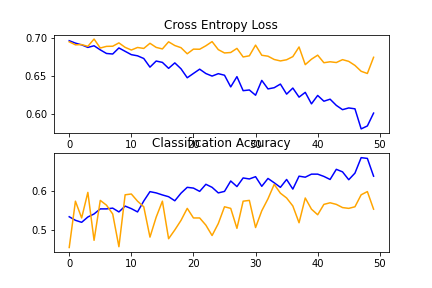

Based on the learning curves, it can be seen that dropout has reduced overfitting, although performance begin to stall towards the end of the run.

## Image Data Augmentation

Small changes to the input photos of dogs and cats might be useful for this problem, such as small shifts and horizontal flips. 

The augmentations can be specified as arguments to the ImageDataGenerator used for the training data. 

The augmentations are not used for the testing dataset, as the model will be evaluated on the unmodified photos.

Each photo in the training dataset are augmented with 10% random horizontal and vertical shifts and random horizontal flips that create a mirror image of the photo.

In [4]:
train_datagen = ImageDataGenerator(rescale=1.0/255.0, width_shift_range=0.1, height_shift_range=0.1, horizontal_flip=True)
test_datagen = ImageDataGenerator(rescale=1.0/255.0)

In [5]:
train_it = train_datagen.flow_from_directory('drive/MyDrive/dataset/train/', class_mode='binary', batch_size=64, target_size=(200, 200))
test_it = test_datagen.flow_from_directory('drive/MyDrive/dataset/test/', class_mode='binary', batch_size=64, target_size=(200, 200))

Found 1518 images belonging to 2 classes.
Found 482 images belonging to 2 classes.


In [6]:
aug_model = define_model()
aug_model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 200, 200, 32)      896       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 100, 100, 32)      0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 100, 100, 64)      18496     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 50, 50, 64)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 50, 50, 128)       73856     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 25, 25, 128)       0         
_________________________________________________________________
flatten (Flatten)            (None, 80000)             0

In [8]:
now = datetime.datetime.now
t = now()
history = aug_model.fit_generator(train_it, steps_per_epoch=len(train_it),
	validation_data=test_it, validation_steps=len(test_it), epochs=50, verbose=0)
print('Training time: %s' % (now() - t))

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/training.py:1844: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Training time: 1:59:43.197917


In [9]:
_, acc = aug_model.evaluate_generator(test_it, steps=len(test_it), verbose=0)
print('> %.3f' % (acc * 100.0))

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/training.py:1877: UserWarning: `Model.evaluate_generator` is deprecated and will be removed in a future version. Please use `Model.evaluate`, which supports generators.
  warnings.warn('`Model.evaluate_generator` is deprecated and '


> 73.237


There is a lift in the model performance from 69% to 73% with image data augmentation.

In [12]:
plot_learning_curves(history)

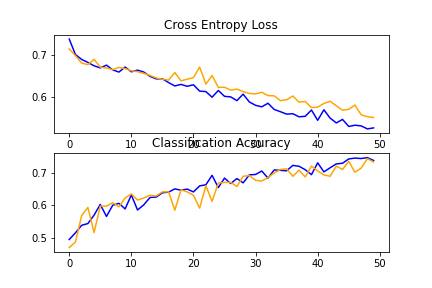

Based on the learning curves, it appears the model is capable of further learning with both the loss on the train and test dataset still decreasing even at the end of the run. 

Using 100 or more epochs will very likely result in a better performing model.

# Build a Transfer Learning CNN Model

A useful model for transfer learning is one of the VGG models, such as VGG-16 with 16 layers, which achieved top results on the ImageNet photo classification challenge.

The model is comprised of two main parts, the feature extractor part of the model that is made up of VGG blocks, and the classifier part of the model that is made up of fully connected layers and the output layer.

The feature extraction part of the model can be used and a new classifier part of the model that is tailored to the dogs and cats dataset is added. Specifically, the weights of all of the convolutional layers is fixed during training, and only train new fully connected layers that will learn to interpret the features extracted from the model and make a binary classification.

The VGG16 model was configured to accept input images in 224 × 224 pixels.

In [ ]:
def define_tl_model():
	# load model
	model = VGG16(include_top=False, input_shape=(224, 224, 3))
	# mark loaded layers as not trainable
	for layer in model.layers:
		layer.trainable = False
	# add new classifier layers
	flat1 = Flatten()(model.layers[-1].output)
	class1 = Dense(128, activation='relu', kernel_initializer='he_uniform')(flat1)
	output = Dense(1, activation='sigmoid')(class1)
	# define new model
	model = Model(inputs=model.inputs, outputs=output)
	# compile model
	opt = SGD(lr=0.01, momentum=0.9) #lr
	model.compile(optimizer=opt, loss='binary_crossentropy', metrics=['accuracy'])
	return model

In [ ]:
tl_model = define_tl_model()
tl_model.summary()

58892288/58889256 [==============================] - 1s 0us/step
Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
______________________________________________________________

The model also expects images to be centered. That is, to have the mean pixel values from each channel (red, green, and blue) as calculated on the ImageNet training dataset subtracted from the input. 

Keras provides a function to perform this preparation for individual photos via the preprocess_input() function. Nevertheless, we can achieve the same effect with the ImageDataGenerator by setting the “featurewise_center” argument to “True” and manually specifying the mean pixel values to use when centering as the mean values from the ImageNet training dataset: [123.68, 116.779, 103.939].

In [ ]:
datagen = ImageDataGenerator(featurewise_center=True)
datagen.mean = [123.68, 116.779, 103.939]

In [ ]:
train_it = datagen.flow_from_directory('drive/MyDrive/dataset/train/', class_mode='binary', batch_size=64, target_size=(224, 224))
test_it = datagen.flow_from_directory('drive/MyDrive/dataset/test/', class_mode='binary', batch_size=64, target_size=(224, 224))

Found 1518 images belonging to 2 classes.
Found 482 images belonging to 2 classes.


In [ ]:
now = datetime.datetime.now
t = now()
history = tl_model.fit_generator(train_it, steps_per_epoch=len(train_it),
		validation_data=test_it, validation_steps=len(test_it), epochs=10, verbose=1)
print('Training time: %s' % (now() - t))

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/training.py:1844: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/10
24/24 [==============================] - 1003s 43s/step - loss: 0.0858 - accuracy: 0.9671 - val_loss: 0.1456 - val_accuracy: 0.9481
Epoch 2/10
24/24 [==============================] - 1006s 42s/step - loss: 0.0838 - accuracy: 0.9677 - val_loss: 0.1032 - val_accuracy: 0.9502
Epoch 3/10
24/24 [==============================] - 1015s 43s/step - loss: 0.0820 - accuracy: 0.9684 - val_loss: 0.1023 - val_accuracy: 0.9502
Epoch 4/10
24/24 [==============================] - 1011s 43s/step - loss: 0.0810 - accuracy: 0.9684 - val_loss: 0.1016 - val_accuracy: 0.9502
Epoch 5/10
24/24 [==============================] - 1009s 42s/step - loss: 0.0802 - accuracy: 0.9684 - val_loss: 0.1009 - val_accuracy: 0.9502
Epoch 6/10
24/24 [==============================] - 1009s 42s/step - loss: 0.0795 - accuracy: 0.9684 - val_loss: 0.1004 - val_accuracy: 0.9502
Epoch 7/10
24/24 [==============================] - 1011s 42s/step - loss: 0.0789 - accuracy: 0.9684 - val_loss: 0.1000 - val_accuracy: 0.9502

In [ ]:
_, acc = tl_model.evaluate_generator(test_it, steps=len(test_it), verbose=0)
print('> %.3f' % (acc * 100.0))

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/training.py:1877: UserWarning: `Model.evaluate_generator` is deprecated and will be removed in a future version. Please use `Model.evaluate`, which supports generators.
  warnings.warn('`Model.evaluate_generator` is deprecated and '


> 95.021


The model has achieved very impressive results with a classification accuracy of about 95% on the holdout testing dataset.

In [ ]:
plot_learning_curves(history)

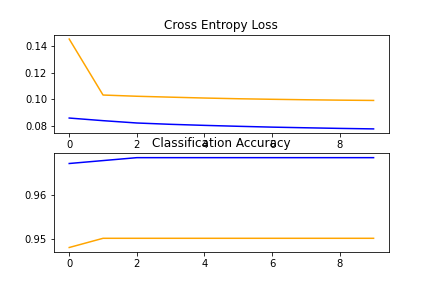

Based on the learning curves, there is a slight sign of overfitting. The model achieved 97% accuracy on training data and 95% accuracy on testing data, which is a 2% difference.

The results suggest that perhaps additional capacity in the classifier and/or the use of dropout regularization and image data augmentation might be helpful.

# Finalize Training Dataset and CNN Model

## Prepare Final Dataset

A new directory is created with all training images organized into dogs and cats subdirectories without any separation into train or test directories.

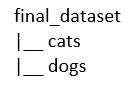

In [ ]:
# specify directories
home_dir = 'drive/MyDrive/final_dataset/'
class_dirs = ['dogs/', 'cats/']

# create directories
for class_dir in class_dirs:
	new_dir = home_dir + class_dir
	makedirs(new_dir, exist_ok=True)

In [ ]:
# copy training dataset images into subdirectories
src_dir = 'drive/MyDrive/train/'
for filename in listdir(src_dir):
	src = src_dir + filename
	if filename.startswith('cat'):
		dst = home_dir + 'cats/' + filename
		copyfile(src, dst)
	else:
		dst = home_dir + 'dogs/' + filename
		copyfile(src, dst)

## Build Final CNN Model

In [ ]:
def define_final_model():
	# load model
	model = VGG16(include_top=False, input_shape=(224, 224, 3))
	# mark loaded layers as not trainable
	for layer in model.layers:
		layer.trainable = False
	# add new classifier layers
	flat1 = Flatten()(model.layers[-1].output)
	class1 = Dense(128, activation='relu', kernel_initializer='he_uniform')(flat1)
	output = Dense(1, activation='sigmoid')(class1)
	# define new model
	model = Model(inputs=model.inputs, outputs=output)
	# compile model
	opt = SGD(lr=0.001, momentum=0.9)
	model.compile(optimizer=opt, loss='binary_crossentropy', metrics=['accuracy'])
	return model

In [ ]:
final_model = define_final_model()

In [ ]:
datagen = ImageDataGenerator(featurewise_center=True)
datagen.mean = [123.68, 116.779, 103.939]

In [ ]:
train_it = datagen.flow_from_directory('drive/MyDrive/final_dataset/', class_mode='binary', batch_size=64, target_size=(224, 224))

Found 2000 images belonging to 2 classes.


In [ ]:
t = now()
final_model.fit_generator(train_it, steps_per_epoch=len(train_it), epochs=10, verbose=0)
print('Training time: %s' % (now() - t))

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/training.py:1844: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Training time: 2:46:08.097351


In [ ]:
final_model.save('drive/MyDrive/final_model.h5')

# Deploy CNN Model for Classification

A function for loading and preparing the image for classification is created.

The image is resized to 224 × 224 pixels. The pixel values must also be centered to match the way that the data was prepared during the training of the model.

In [ ]:
def load_image(filename):
	# load the image
	img = load_img(filename, target_size=(224, 224))
	# convert to array
	img = img_to_array(img)
	# reshape into a single sample with 3 channels
	img = img.reshape(1, 224, 224, 3)
	# center pixel data
	img = img.astype('float32')
	img = img - [123.68, 116.779, 103.939]
	return img

Since each of the subdirectories of the class labels are loaded by the flow_from_directory() function in alphabetical order and assigned an integer, the class labels are assigned the integers: cat=0, dog=1.

In [ ]:
def run_classification(img_name):
  # load the image
  img_dir = 'drive/MyDrive/' + img_name
  img = load_image(img_dir)
  # load model
  model = load_model('drive/MyDrive/final_model.h5')
  # classify the image
  result = model.predict(img)
  prediction = round(result[0][0])
  if (prediction==1):
    predicted_class = 'Dog'
    confidence = round(result[0][0] * 100, 1)
  else:
    predicted_class = 'Cat'
    confidence = round(100 - result[0][0] * 100, 1)
  print(predicted_class, "(", confidence, "%)")

In [ ]:
def classify(img_name):
  img = imread('drive/MyDrive/' + img_name)
  pyplot.imshow(img)
  pyplot.show()
  run_classification(img_name)

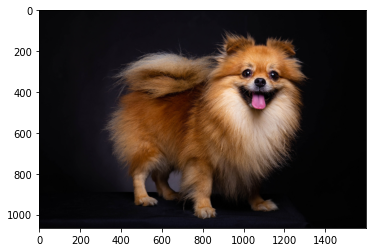

Dog ( 98.9 %)


In [ ]:
classify('sample1.jpg')

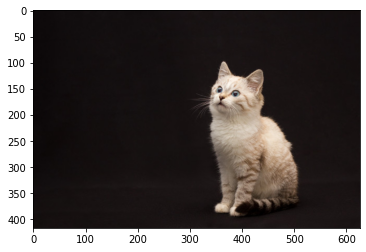

Cat ( 100.0 %)


In [ ]:
classify('sample2.jpg')

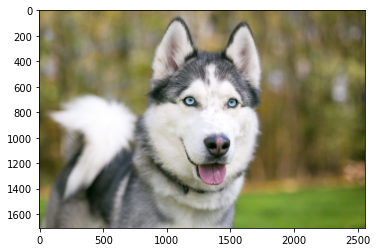

Dog ( 100.0 %)


In [ ]:
classify('sample3.jpg')

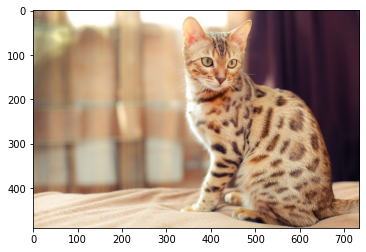

Cat ( 100.0 %)


In [ ]:
classify('sample4.jpg')

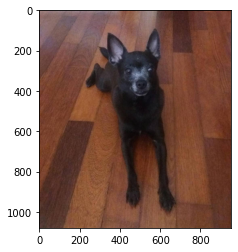

Dog ( 100.0 %)


In [ ]:
classify('sample5.jpeg')